In [25]:
import pandas as pd

data_4_1a = pd.read_csv('assignment4.1a.csv', parse_dates=['Date'])

data_4_1a.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-01-01,8,9,-1
1,2015-01-01,131,9,1
2,2015-01-01,144,9,2
3,2015-01-01,203,9,2
4,2015-01-01,256,9,0


In [26]:
promotion_dates = pd.read_csv('PromotionDates.csv', parse_dates=['StartDate', 'EndDate'])

promotion_dates.head()


,Period,StartDate,EndDate
0,Promo1,2015-02-10,2015-02-17
1,Promo2,2015-03-15,2015-03-22
2,Promo3,2015-05-24,2015-06-01
3,Promo4,2015-06-21,2015-06-28
4,Promo5,2015-09-01,2015-09-06


In [27]:
data_4_1b = pd.read_csv('assignment4.1b.csv', parse_dates=['Date'])
data_4_1b.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-08-01,2,9,1
1,2015-08-01,7,9,1
2,2015-08-01,62,9,1
3,2015-08-01,181,9,1
4,2015-08-01,6,20,1


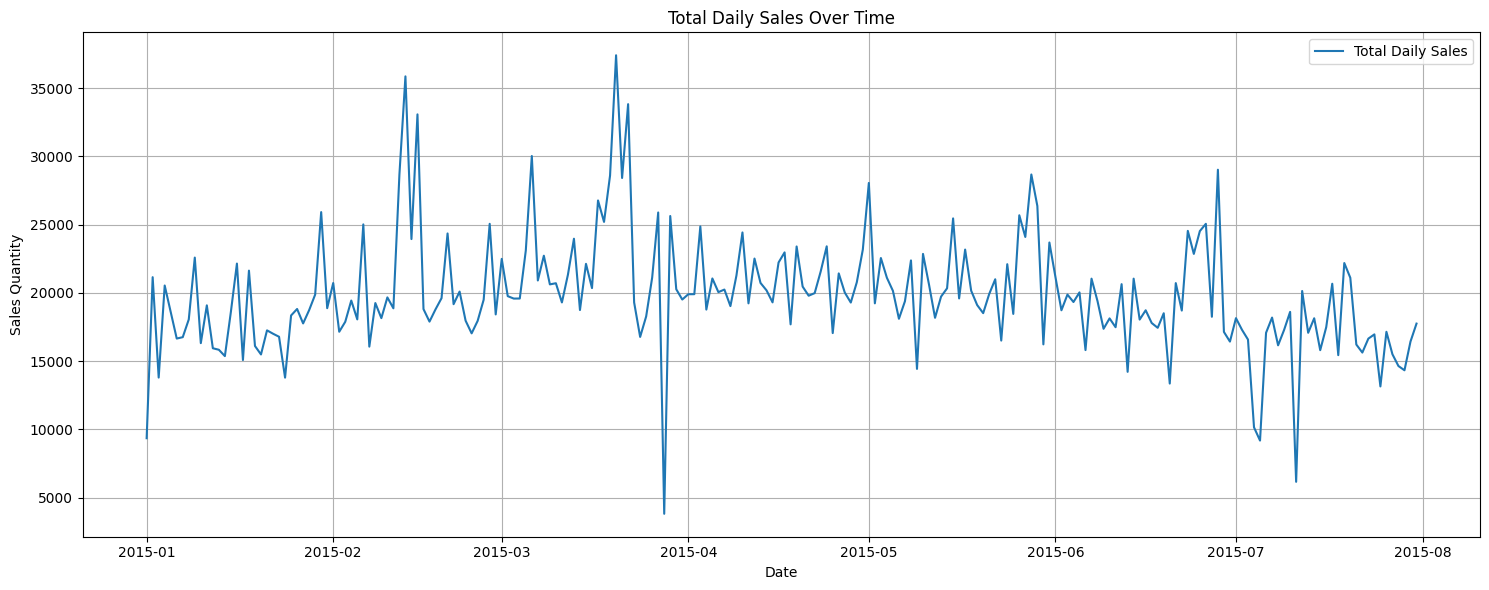

In [28]:
import matplotlib.pyplot as plt

# group by date and sum
total_daily_sales = data_4_1a.groupby('Date').SalesQuantity.sum()

plt.figure(figsize=(15, 6))
plt.plot(total_daily_sales, label='Total Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.title('Total Daily Sales Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
promo_periods = promotion_dates.iloc[:4].copy()

# init dummy column
data_4_1a['Is_Promotion'] = 0

# 1 for promo, else 0
for _, row in promo_periods.iterrows():
    mask = (data_4_1a['Date'] >= row['StartDate']) & (data_4_1a['Date'] <= row['EndDate'])
    data_4_1a.loc[mask, 'Is_Promotion'] = 1

data_4_1a.head()


,Date,StoreCode,ProductCode,SalesQuantity,Is_Promotion
0,2015-01-01,8,9,-1,0
1,2015-01-01,131,9,1,0
2,2015-01-01,144,9,2,0
3,2015-01-01,203,9,2,0
4,2015-01-01,256,9,0,0


To model the effect of promotions on sales, we'll employ the `SARIMAX` (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model. This model will allow us to incorporate the `Is_Promotion` column as an exogenous variable, helping us to measure the promotional effect on sales.

In [30]:
# daily sales across all store and product combinations
daily_sales = data_4_1a.groupby('Date').agg({'SalesQuantity': 'sum', 'Is_Promotion': 'max'}).reset_index()

daily_sales.head()


,Date,SalesQuantity,Is_Promotion
0,2015-01-01,9355,0
1,2015-01-02,21156,0
2,2015-01-03,13799,0
3,2015-01-04,20545,0
4,2015-01-05,18615,0


For SARIMAX, we need to determine the order parameters (p, d, q) for the ARIMA part and (P, D, Q, S) for the seasonal part. A common approach to determine these parameters is to use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots, but this can be time-consuming. Another approach is to use a grid search over a set of possible parameters and select the best one based on a metric like AIC (Akaike Information Criterion).

For simplicity, I'll use a predefined set of parameters and fit the SARIMAX model. Later, if needed, we can fine-tune these parameters.

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# the dependent and exogenous variables
y = daily_sales['SalesQuantity']
X = daily_sales['Is_Promotion']

# fit the SARIMAX model
model = SARIMAX(y, exog=X, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit(disp=-1)

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     SalesQuantity   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1915.748
Date:                           Thu, 19 Oct 2023   AIC                           3843.496
Time:                                   01:43:42   BIC                           3863.405
Sample:                                        0   HQIC                          3851.550
                                           - 212                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Is_Promotion  3771.8368    751.957      5.016      0.000    2298.029    5245.645
ar.L1            0.2888      0.126      2.286      0.022       0.041       0.536
ma.L1           -0.7830      0.089     -8.845      0.000      -0.957      -0.610
ar.S.L7         -0.1599      0.082     -1.950      0.051      -0.321       0.001
ma.S.L7         -0.8413      0.062    -13.469      0.000      -0.964      -0.719
sigma2        7.968e+06   4.64e+05     17.183      0.000    7.06e+06    8.88e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               263.56
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.52
Prob(H) (two-sided):                  0.43   Kurtosis:                         8.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

`Is_Promotion` Coefficient: The coefficient for `Is_Promotion` is 3771.8368, which indicates that, on average, there's an **increase of about 3772 units** in sales during promotional days compared to non-promotional days.

P-Value for `Is_Promotion`: The p-value for the `Is_Promotion` coefficient is statistically significant (less than 0.05), which suggests that the promotional effect on sales is statistically significant.

Model Diagnostics: The Ljung-Box test (for residual autocorrelations) has a high p-value, indicating that the residuals are likely white noise, which is a good sign for our model. However, the Jarque-Bera test indicates that the residuals are not normally distributed. We might want to investigate this further.

In [32]:
promo5_period = promotion_dates.iloc[4].copy()

data_4_1b = pd.read_csv('assignment4.1b.csv', parse_dates=['Date'])

data_4_1b['Is_Promotion'] = 0

mask = (data_4_1b['Date'] >= promo5_period['StartDate']) & (data_4_1b['Date'] <= promo5_period['EndDate'])
data_4_1b.loc[mask, 'Is_Promotion'] = 1

# daily sales for the test data
daily_sales_test = data_4_1b.groupby('Date').agg({'SalesQuantity': 'sum', 'Is_Promotion': 'max'}).reset_index()

daily_sales_test.head()


,Date,SalesQuantity,Is_Promotion
0,2015-08-01,14652,0
1,2015-08-02,19566,0
2,2015-08-03,16859,0
3,2015-08-04,15556,0
4,2015-08-05,15657,0


In [33]:
# make predictions on the test data
forecast = results.predict(start=len(daily_sales), end=len(daily_sales) + len(daily_sales_test) - 1, 
                           exog=daily_sales_test[['Is_Promotion']], dynamic=True)

# forecasted sales with the actual sales in the test data
daily_sales_test['ForecastedSales'] = forecast.values

daily_sales_test.head(10)


,Date,SalesQuantity,Is_Promotion,ForecastedSales
0,2015-08-01,14652,0,10812.176591
1,2015-08-02,19566,0,17290.038346
2,2015-08-03,16859,0,15531.749447
3,2015-08-04,15556,0,15545.070150
4,2015-08-05,15657,0,14918.468022
5,2015-08-06,16403,0,15959.670508
6,2015-08-07,18844,0,17515.389978
7,2015-08-08,12941,0,10861.866991
8,2015-08-09,16932,0,16883.027822
9,2015-08-10,15013,0,15124.864622


In [34]:
# Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, forecast):
    return ((abs(actual - forecast) / actual).mean()) * 100

mape = calculate_mape(daily_sales_test['SalesQuantity'], daily_sales_test['ForecastedSales'])

# forecasted sales without the promotion effect
daily_sales_test['ForecastedSales_NoPromo'] = daily_sales_test['ForecastedSales'] - daily_sales_test['Is_Promotion'] * results.params['Is_Promotion']

# average increase in sales due to Promotion 5
promo_period_mask = daily_sales_test['Is_Promotion'] == 1

# coef
average_increase_due_to_promo = (daily_sales_test.loc[promo_period_mask, 'ForecastedSales'] - daily_sales_test.loc[promo_period_mask, 'ForecastedSales_NoPromo']).mean()

mape, average_increase_due_to_promo


(69.15278515501615, 3771.8367915854324)

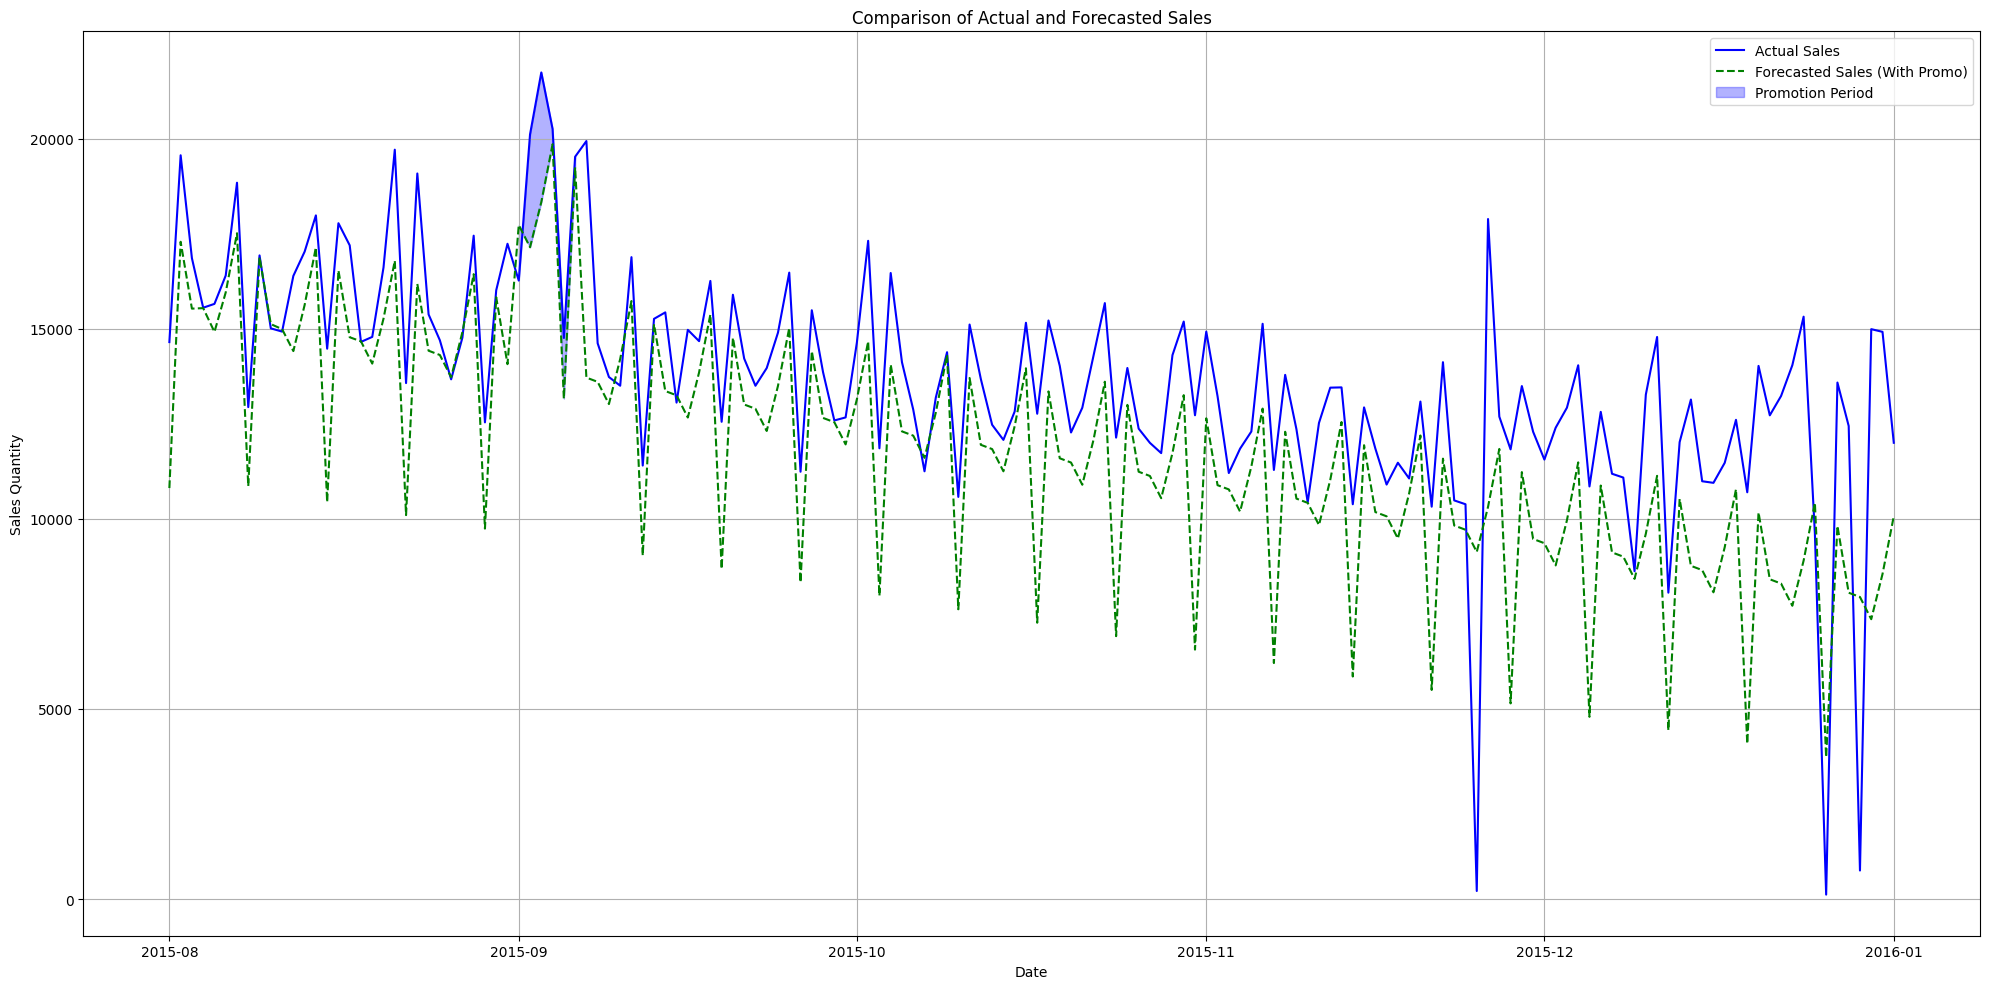

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(daily_sales_test['Date'], daily_sales_test['SalesQuantity'], label='Actual Sales', color='blue')
plt.plot(daily_sales_test['Date'], daily_sales_test['ForecastedSales'], label='Forecasted Sales (With Promo)', color='green', linestyle='--')
plt.fill_between(daily_sales_test['Date'], daily_sales_test['SalesQuantity'], daily_sales_test['ForecastedSales'], 
                 where=(daily_sales_test['Is_Promotion'] == 1), color='blue', alpha=0.3, label='Promotion Period')
plt.title('Comparison of Actual and Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Blue Line: Represents the actual observed sales.
# Green Dashed Line: Represents the forecasted sales considering the promotional effect.
# Blue Shaded Region: Highlights the period during which Promotion 5 was active.

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) for the test data
mae_test = mean_absolute_error(daily_sales_test['SalesQuantity'], daily_sales_test['ForecastedSales'])
rmse_test = np.sqrt(mean_squared_error(daily_sales_test['SalesQuantity'], daily_sales_test['ForecastedSales']))

mae_test, rmse_test


(2216.9697164460367, 2889.081888385184)

The MAE indicates that, on average, our forecasts deviate from the actual sales by around 2217 units.
The RMSE provides a measure of the model's prediction error in terms of the sales quantity. A higher RMSE indicates larger errors and more variability in the predictions.

Time Series Analysis with SARIMAX:

We aggregated daily sales data across all store and product combinations from Assignment4.1a.csv.
Using SARIMAX, we modeled the sales data with Is_Promotion as an exogenous variable.
The SARIMAX model indicates that, on average, there's an increase of about 3772 units in sales during promotional days compared to non-promotional days.
Evaluation on Assignment4.1b.csv:

We marked the test data (Assignment4.1b.csv) with the Is_Promotion flag for Promotion 5.
Using the SARIMAX model trained on the first dataset, we forecasted sales for the period in the test dataset.
The Mean Absolute Percentage Error (MAPE) for our predictions is approximately 69.15%, suggesting that the forecasts deviate from the actual values by this percentage.
The average increase in sales due to Promotion 5, as per our model, is approximately 3772 units.

#### Granularity of Analysis: 

While our analysis aggregated data at the daily level across all store and product combinations, we might have missed item-specific or store-specific promotional effects. We have 83,612 unique store-item combinations in the dataset. Modeling each combination separately would be computationally intensive and might not provide stable estimates,

#### Main Problem Points Causing Bad Fits:
Model Parameters: The parameters for the SARIMAX model were chosen based on common practices, but they might not be optimal. Fine-tuning these parameters using grid search or similar techniques could improve the fit.

Parameter Optimization: Employ techniques like grid search or auto ARIMA to find the best parameters for the SARIMAX model.

Additional Exogenous Variables: Consider including more exogenous variables that might influence sales, such as holidays, weekends, or other special events.